In [128]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import empyrical as ep
import pyfolio as pf
from collections import OrderedDict
from IPython.display import display, HTML
%matplotlib inline

In [144]:
!git add TSMOMENTUM.ipynb
!git commit -m "double check through excel"
!git push

The file will have its original line endings in your working directory


[master d58a4f5] double check through excel
 1 file changed, 3111 insertions(+), 123 deletions(-)


In [159]:

def symbol_to_path(symbol, base_dir="AdjDaily"):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

def get_data(symbols, dates,col):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    if 'TASI' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'TASI')
    dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')
    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date',
                parse_dates=['Date'],date_parser=dateparse, usecols=['Date', col ], na_values=['nan'])
        df_temp = df_temp.rename(columns={col: symbol})
        df = df.join(df_temp)

        if symbol == 'TASI':  # drop dates SPY did not trad
            df = df.dropna(subset=["TASI"])

    return df

def load_df():
    dates = pd.date_range('01/01/2002', '01/01/2017')
    N= (dates[-1]-dates[0])/365
    N = str(N).split()[0]
    files = os.listdir("AdjDaily")
    symbols=[]
    for name in files:
        if name[0].isdigit():
            symbols.append(name.split('.')[0])
    df = get_data(symbols, dates, 'Close')
    df.to_pickle('database.pkl')
    return df
def normalize_data(df):
    return df/df.iloc[0,:]

def compute_daily_returns(df):
    daily_returns = (df/df.shift(1))-1
    daily_returns = daily_returns[1:]
    return daily_returns

def stats(df,period):
    if period == 'W':
        p = 52.0
    if period == 'M':
        p = 12.0
    if period == 'D':
        p = 365.0
    cagr = (df.iloc[-1]/df.iloc[0])**(1.0/(len(df)/p)) - 1.0
    dr = compute_daily_returns(df)
    sharpe = np.sqrt(p) * dr.mean() / dr.std()
    print (' CAGR(%) = ' + str(cagr * 100))
    print (' Sharpe ratio = ' + str(sharpe))

def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

def pos_val(df,capital=100000,alloc=[]):
    if alloc == []:
        alloc= 1.0/len(df.columns)
    return (normalize_data(df) * alloc * capital).sum(axis=1)

# This function creates chunks and returns them
def chunkify(lst,n):
    return [ lst[i::n] for i in np.arange(n) ]

def portfolio(df,holdPeriod,capital=100000):
    if isinstance(df,pd.DataFrame):
#         capital = df.shape[1] * 1000
        alloc = 1 / df.shape[1]
    else:
#         capital = 1000
        alloc = 1 
    postions = norm(df[:holdPeriod]) * alloc * capital * 0.99845 # Trading Commissions
    if isinstance(df,pd.DataFrame):
        portfolio = postions.sum(axis=1)
    else:
        portfolio = postions
    return portfolio

def norm(df):
    if isinstance(df,pd.DataFrame):
        mask = df.iloc[0].isnull()
        df = df.loc[:,~mask]
        mask = df.iloc[0]==0
        df = df.loc[:,~mask]
    df = df / df.iloc[0]
    return df

# https://github.com/quantopian/pyfolio/blob/13af662b5c3851ede1f1910bf3c3acfca3b53c52/pyfolio/utils.py#L170
def print_table(table,
                name=None,
                float_format=None,
                formatters=None,
                header_rows=None):
    """
    Pretty print a pandas DataFrame.
    Uses HTML output if running inside Jupyter Notebook, otherwise
    formatted text output.
    Parameters
    ----------
    table : pandas.Series or pandas.DataFrame
        Table to pretty-print.
    name : str, optional
        Table name to display in upper left corner.
    float_format : function, optional
        Formatter to use for displaying table elements, passed as the
        `float_format` arg to pd.Dataframe.to_html.
        E.g. `'{0:.2%}'.format` for displaying 100 as '100.00%'.
    formatters : list or dict, optional
        Formatters to use by column, passed as the `formatters` arg to
        pd.Dataframe.to_html.
    header_rows : dict, optional
        Extra rows to display at the top of the table.
    """

    if isinstance(table, pd.Series):
        table = pd.DataFrame(table)

    if name is not None:
        table.columns.name = name

    html = table.to_html(float_format=float_format, formatters=formatters)

    if header_rows is not None:
        # Count the number of columns for the text to span
        n_cols = html.split('<thead>')[1].split('</thead>')[0].count('<th>')

        # Generate the HTML for the extra rows
        rows = ''
        for name, value in header_rows.items():
            rows += ('\n    <tr style="text-align: right;"><th>%s</th>' +
                     '<td colspan=%d>%s</td></tr>') % (name, n_cols, value)

        # Inject the new HTML
        html = html.replace('<thead>', '<thead>' + rows)
    display(HTML(html))
    
percentage_formatter = '{:.2%}'.format
float_formatter = '{:.2f}'.format

In [106]:
sb.set()
sb.set_color_codes("deep")
# Change the default figure size
# https://stackabuse.com/python-data-visualization-with-matplotlib/
fig_size = plt.rcParams["figure.figsize"]  
fig_size[0] = 20  
fig_size[1] = 10  
plt.rcParams["figure.figsize"] = fig_size 

In [107]:
data = pd.read_pickle('AdjustedClose.pkl')

In [108]:
df = data.xs(slice('01/01/2010','30/09/2019'),level=1,drop_level=False)
df.head()
bh = df[['AdjClose']].unstack(level=0)
bh = bh.droplevel(0,1)
df = df[['Close']].unstack(level=0)
# returns = df.resample('BM').mean()
df = df.droplevel(0,1)
# returns = returns.droplevel(0,1)
# df = df.dropna(subset=["TASI"])
# tasi = df['TASI'].copy()
# df = df.drop('TASI',axis=1)         

In [180]:
mom.head(93)

Symbol,1010,1020,1030,1040,1050,1060,1080,1090,1120,1140,...,8240,8250,8260,8270,8280,8290,8300,8310,8311,8312
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [175]:
lookback = 90
mom = (df - df.shift(lookback))*0.5

In [110]:
mom = mom[lookback:]
mask = mom.iloc[0].isnull()
mom = mom.loc[:,~mask]

In [8]:
porto = hold.sort_values(by=hold.index.values[0], ascending=False, axis=1)
porto.head()

Symbol,2360,2010,3030,2290,2020,4190,2040,4001,2240,8010,...,8100,8080,4160,4140,6050,2370,8040,8110,8220,2110
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-08,9.200,8.625,5.700,5.35,3.9,3.845,2.970,2.650,2.35,2.32,...,-5.120,-5.20,-7.40,-7.780,-7.945,-8.335,-9.35,-9.490,-12.750,-22.320
2010-05-09,9.800,9.375,5.975,5.90,4.1,4.125,3.830,2.925,2.70,2.48,...,-4.790,-4.95,-6.95,-6.565,-5.425,-7.845,-8.95,-9.320,-12.200,-20.440
2010-05-10,10.500,9.000,6.375,6.45,4.5,4.685,3.670,3.250,3.80,3.52,...,-3.675,-4.50,-6.80,-5.355,-5.430,-7.320,-8.65,-7.820,-9.575,-18.725
2010-05-11,9.600,8.125,6.275,5.75,4.2,4.875,3.520,3.150,4.00,4.00,...,-3.780,-4.30,-6.70,-5.555,-5.165,-7.695,-7.70,-6.785,-7.100,-20.275
2010-05-12,9.675,8.250,6.150,5.15,3.9,4.785,3.435,2.950,4.20,3.56,...,-4.185,-3.90,-6.80,-5.455,-5.425,-7.620,-7.75,-5.995,-7.750,-18.885


In [19]:
tickers = np.array(porto.columns)
tickers

array([2360, 2010, 3030, 2290, 2020, 4190, 2040, 4001, 2240, 8010, 1120,
       2320, 2280, 6001, 7020, 1050, 2050, 2230, 8030, 1090, 2260, 4100,
       2060, 3020, 1211, 2350, 2070, 4030, 2002, 2200, 1212, 4002, 3050,
       1010, 4280, 1080, 2270, 1040, 1060, 6090, 2300, 4150, 1030, 4250,
       2250, 2140, 7040, 4240, 2310, 4200, 2150, 6080, 4040, 3040, 2190,
       4080, 4090, 1140, 2001, 5110, 2130, 4300, 1210, 4220, 8210, 4020,
       4290, 4050, 2120, 1150, 1020, 4180, 2100, 3090, 6060, 8200, 4260,
       4010, 2330, 6040, 8070, 2170, 4270, 4130, 6020, 4110, 8170, 1310,
       4070, 8060, 8190, 2080, 8180, 2220, 4230, 2210, 2090, 3060, 8280,
       1320, 8090, 6010, 8250, 2380, 7010, 3010, 8140, 4210, 6070, 8150,
       7030, 2160, 8130, 4061, 3080, 4170, 2030, 8240, 8160, 2340, 8120,
       8020, 8050, 2180, 8230, 8100, 8080, 4160, 4140, 6050, 2370, 8040,
       8110, 8220, 2110], dtype=int64)

In [20]:
for array in chunkify(tickers,10):
    print(len(array))

14
14
14
14
14
13
13
13
13
13


In [33]:
holdPeriod = 90
quartiles = df.loc[porto.index.values[0]:]
quartiles = quartiles[tickers[14:28]]
test = portfolio(quartiles,holdPeriod)

In [111]:
buy = mom > 0
buy.apply(pd.value_counts,axis=1)

,False,True
Date,,
2010-05-08,84,51
2010-05-09,82,53
2010-05-10,81,54
2010-05-11,82,53
2010-05-12,78,57
2010-05-15,87,48
2010-05-16,87,48
2010-05-17,87,48
2010-05-18,85,50


In [112]:
buy = buy*1
pos = buy.diff()
pos = pos.combine_first(buy)

In [129]:
pos.apply(pd.value_counts,axis=1)

,-1.0,0.0,1.0
Date,,,
2010-05-08,NaN,84.0,51.0
2010-05-09,NaN,133.0,2.0
2010-05-10,NaN,134.0,1.0
2010-05-11,3.0,130.0,2.0
2010-05-12,1.0,129.0,5.0
2010-05-15,9.0,126.0,NaN
2010-05-16,3.0,129.0,3.0
2010-05-17,2.0,131.0,2.0
2010-05-18,1.0,131.0,3.0


In [120]:
hold = df[mom.columns][lookback:]
mask = hold.iloc[0].isnull()
hold = hold.loc[:,~mask]
cash_val = hold * pos * -1
stk_val = hold * buy

In [130]:
stk_val

Symbol,1010,1020,1030,1040,1050,1060,1080,1090,1120,1140,...,8170,8180,8190,8200,8210,8220,8230,8240,8250,8280
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-08,14.25,0.0,11.32,9.42,27.83,22.60,19.21,25.74,47.27,0.00,...,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
2010-05-09,14.45,0.0,11.40,9.48,28.13,22.73,19.47,26.88,49.23,0.00,...,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
2010-05-10,14.50,0.0,11.56,9.59,27.98,23.00,19.61,26.88,49.38,0.00,...,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
2010-05-11,14.50,0.0,11.52,9.54,28.05,23.13,19.47,26.46,48.78,0.00,...,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
2010-05-12,14.45,0.0,11.48,9.59,28.20,23.33,19.41,26.34,48.78,0.00,...,0.0,30.50,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
2010-05-15,14.25,0.0,11.32,9.52,27.83,22.73,0.00,26.58,47.73,0.00,...,0.0,31.88,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
2010-05-16,14.40,0.0,11.52,9.69,27.83,22.73,19.41,26.10,47.73,0.00,...,0.0,31.56,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
2010-05-17,14.55,0.0,11.48,9.69,27.75,22.60,19.21,26.22,47.27,8.05,...,0.0,32.81,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
2010-05-18,14.50,0.0,11.52,9.73,27.83,22.60,19.14,26.46,48.33,8.08,...,0.0,32.66,23.57,0.00,0.0,0.0,0.0,0.00,0.00,0.0


In [121]:
cash_val = cash_val.sum(axis=1) 
cash_val.iloc[0]=313
cash_val = cash_val.cumsum()
mkt_val = stk_val.sum(axis=1)

In [122]:
cash_val

Date
2010-05-08     313.00
2010-05-09     224.95
2010-05-10     209.45
2010-05-11     170.63
2010-05-12      67.29
2010-05-15     401.01
2010-05-16     344.03
2010-05-17     332.84
2010-05-18     236.09
2010-05-19     510.34
2010-05-22     588.75
2010-05-23     950.16
2010-05-24    1094.29
2010-05-25    1471.72
2010-05-26    1340.76
2010-05-29     949.00
2010-05-30    1060.17
2010-05-31    1012.43
2010-06-01    1097.58
2010-06-02    1075.25
2010-06-05    1147.62
2010-06-06    1173.50
2010-06-07     997.85
2010-06-08    1198.40
2010-06-09     968.38
2010-06-12     525.71
2010-06-13     703.03
2010-06-14     676.38
2010-06-15     597.35
2010-06-16     573.81
               ...   
2019-08-19     216.20
2019-08-20     271.42
2019-08-21     295.60
2019-08-22     665.96
2019-08-25     823.99
2019-08-26     885.22
2019-08-27     841.25
2019-08-28     790.49
2019-08-29     866.39
2019-09-01     915.09
2019-09-02     963.19
2019-09-03    1074.19
2019-09-04     883.24
2019-09-05     991.99
2019-

In [116]:
mkt_val

Date
2010-05-08    1686.56
2010-05-09    1810.68
2010-05-10    1854.18
2010-05-11    1874.67
2010-05-12    1967.32
2010-05-15    1592.25
2010-05-16    1644.44
2010-05-17    1649.31
2010-05-18    1760.29
2010-05-19    1437.96
2010-05-22    1338.56
2010-05-23     969.92
2010-05-24     812.06
2010-05-25     390.33
2010-05-26     530.48
2010-05-29     940.97
2010-05-30     822.53
2010-05-31     876.72
2010-06-01     776.54
2010-06-02     802.00
2010-06-05     719.61
2010-06-06     693.48
2010-06-07     870.44
2010-06-08     671.57
2010-06-09     906.38
2010-06-12    1369.87
2010-06-13    1183.54
2010-06-14    1222.29
2010-06-15    1301.32
2010-06-16    1326.27
               ...   
2019-08-19    1918.31
2019-08-20    1870.83
2019-08-21    1834.52
2019-08-22    1452.51
2019-08-25    1268.95
2019-08-26    1211.04
2019-08-27    1279.36
2019-08-28    1315.16
2019-08-29    1224.58
2019-09-01    1179.20
2019-09-02    1141.46
2019-09-03    1025.31
2019-09-04    1224.60
2019-09-05    1105.98
2019-

In [123]:
nav = mkt_val + cash_val
nav

Date
2010-05-08    1999.56
2010-05-09    2035.63
2010-05-10    2063.63
2010-05-11    2045.30
2010-05-12    2034.61
2010-05-15    1993.26
2010-05-16    1988.47
2010-05-17    1982.15
2010-05-18    1996.38
2010-05-19    1948.30
2010-05-22    1927.31
2010-05-23    1920.08
2010-05-24    1906.35
2010-05-25    1862.05
2010-05-26    1871.24
2010-05-29    1889.97
2010-05-30    1882.70
2010-05-31    1889.15
2010-06-01    1874.12
2010-06-02    1877.25
2010-06-05    1867.23
2010-06-06    1866.98
2010-06-07    1868.29
2010-06-08    1869.97
2010-06-09    1874.76
2010-06-12    1895.58
2010-06-13    1886.57
2010-06-14    1898.67
2010-06-15    1898.67
2010-06-16    1900.08
               ...   
2019-08-19    2134.51
2019-08-20    2142.25
2019-08-21    2130.12
2019-08-22    2118.47
2019-08-25    2092.94
2019-08-26    2096.26
2019-08-27    2120.61
2019-08-28    2105.65
2019-08-29    2090.97
2019-09-01    2094.29
2019-09-02    2104.65
2019-09-03    2099.50
2019-09-04    2107.84
2019-09-05    2097.97
2019-

In [124]:
ep.aggregate_returns(compute_daily_returns(nav),'yearly') 

2010   -0.034448
2011    0.022837
2012    0.008057
2013    0.260333
2014    0.188503
2015   -0.108312
2016   -0.137561
2017   -0.130512
2018    0.037234
2019    0.021179
dtype: float64

In [125]:
pf.show_perf_stats(compute_daily_returns(nav))

Start date,2010-05-09
End date,2019-09-30
Total months,111
,Backtest
Annual return,0.6%
Cumulative returns,5.6%
Annual volatility,17.1%
Sharpe ratio,0.12
Calmar ratio,0.01
Stability,0.02
Max drawdown,-52.9%


In [163]:
from collections import defaultdict
holdPeriod = 30
returns = mom[1000:]
epochs = int((np.floor(returns.shape[0])/(holdPeriod)))
print(epochs)
newCapital = 100000
deciles = defaultdict(dict)
for i in range(0,10):
    # First loop 
    if i == 0:
        mask = returns.iloc[0].isnull()
        hold = returns.loc[:,~mask]
        hold = hold[:holdPeriod]
        h = holdPeriod
    else:
        h = (holdPeriod * i)
        hold = returns[h:holdPeriod*(i+1)]
        mask = hold.iloc[0].isnull()
        hold = hold.loc[:,~mask]  
    tickers = hold.max().sort_values(ascending=False)
    tickers = tickers[:30].index
#     print(tickers)
    prices = df[df.index.get_loc(hold.index.values[0]):]
    
    if i == 0:
    # If first loop use 100k as starting capital, else use the capital from last trade
        newCapital = 100000.0
    else:
        if len(deciles) != 0:
            newCapital = list(deciles.values())[-1]
#             print(deciles)
        else:
            pass
    print(newCapital)
    if len(tickers) != 0:
        print('Hold Stocks')
        prices = prices[tickers]
    #     print(np.array(prices.columns))
        port = portfolio(prices,holdPeriod,newCapital)
        if i == 8:
            norm(prices[:holdPeriod]).to_excel("prices epoch "+str(i)+".xlsx")
            port.to_excel("port.xlsx")
        for index, row in port.iteritems():
            deciles.update({index:row})                
    else:
        print('Go Cash')
        prices = prices[:holdPeriod]
        port = pd.Series(index=prices.index,data=[newCapital]*len(prices.index))
        for index, row in port.iteritems():
            deciles.update({index:row})     
print(newCapital)
print(list(deciles.values())[-1])
final = pd.Series(deciles)
fdr = compute_daily_returns(final)

44
100000.0
Hold Stocks
91418.1463980862
Hold Stocks
100548.2197556459
Hold Stocks
105586.80783156391
Hold Stocks
103308.8744924421
Hold Stocks
87600.56379675509
Hold Stocks
92382.20592827609
Hold Stocks
96303.6966558302
Hold Stocks
104215.94074619928
Hold Stocks
104703.20692704442
Hold Stocks
104703.20692704442
101576.00003737246


In [167]:
mask = returns.iloc[0].isnull()
hold = returns.loc[:,~mask]
hold = hold[:30]
tickers = hold.max().sort_values(ascending=False)

Symbol,1010,1020,1030,1040,1050,1060,1080,1090,1120,1140,...,8170,8180,8190,8200,8210,8220,8230,8240,8250,8280
Date,,,,,,,,,,,,,,,,,,,,,
2014-05-13,1.655,1.270,0.555,1.125,2.910,1.800,0.365,0.770,0.250,2.395,...,1.240,4.725,1.660,1.130,8.235,-2.830,2.075,1.945,3.545,13.475
2014-05-14,1.625,1.320,0.575,1.125,2.635,2.065,0.370,0.690,0.350,2.420,...,1.975,4.670,1.965,1.110,7.320,-2.900,2.120,2.455,3.580,13.960
2014-05-15,1.445,1.405,0.580,1.295,2.610,2.000,0.420,0.600,0.330,2.405,...,1.730,4.740,1.885,1.190,7.385,-2.765,2.070,4.310,3.620,14.145
2014-05-18,1.165,1.350,0.220,1.300,2.710,1.700,0.365,0.575,0.065,2.225,...,2.380,4.715,1.950,1.245,7.240,-2.805,2.525,3.820,3.790,14.330
2014-05-19,0.755,1.145,-0.120,1.270,2.730,1.450,0.230,0.500,-0.125,2.130,...,3.155,4.225,1.855,1.140,6.805,-3.100,2.165,3.220,3.450,14.105
2014-05-20,0.800,1.245,0.000,1.155,2.555,1.490,0.200,0.590,-0.175,2.240,...,3.345,4.245,2.145,1.160,6.085,-3.220,2.250,3.415,3.350,16.760
2014-05-21,0.805,1.430,0.085,1.165,2.510,1.465,0.265,0.335,-0.240,2.660,...,3.265,4.060,2.475,1.170,6.250,-2.255,2.375,3.400,3.495,18.000
2014-05-22,0.805,1.740,0.160,1.095,2.730,1.450,0.230,0.305,-0.210,2.325,...,3.605,4.005,2.500,1.180,6.110,-2.450,2.120,4.035,3.185,17.070
2014-05-25,0.835,1.740,0.150,1.085,2.470,1.235,0.170,0.240,-0.125,2.575,...,3.430,3.675,2.720,1.005,6.495,-2.525,2.240,3.850,2.995,16.220


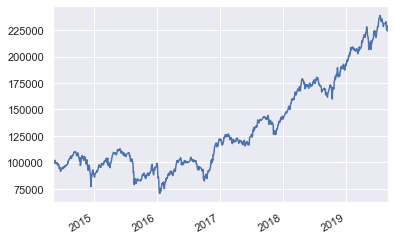

In [153]:
final.plot()

Start date,2014-05-14
End date,2019-09-03
Total months,62
,Backtest
Annual return,16.8%
Cumulative returns,125.6%
Annual volatility,20.5%
Sharpe ratio,0.86
Calmar ratio,0.45
Stability,0.79
Max drawdown,-37.5%


C:\Users\aalot\Miniconda2\envs\udacity\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,37.46,2015-06-02,2016-01-17,2016-12-01,393
1,30.03,2014-09-17,2014-12-16,2015-05-18,174
2,12.48,2017-10-05,2017-11-20,2018-01-10,70
3,11.44,2018-07-16,2018-10-14,2018-10-31,78
4,10.36,2014-05-21,2014-06-23,2014-08-10,58


C:\Users\aalot\Miniconda2\envs\udacity\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


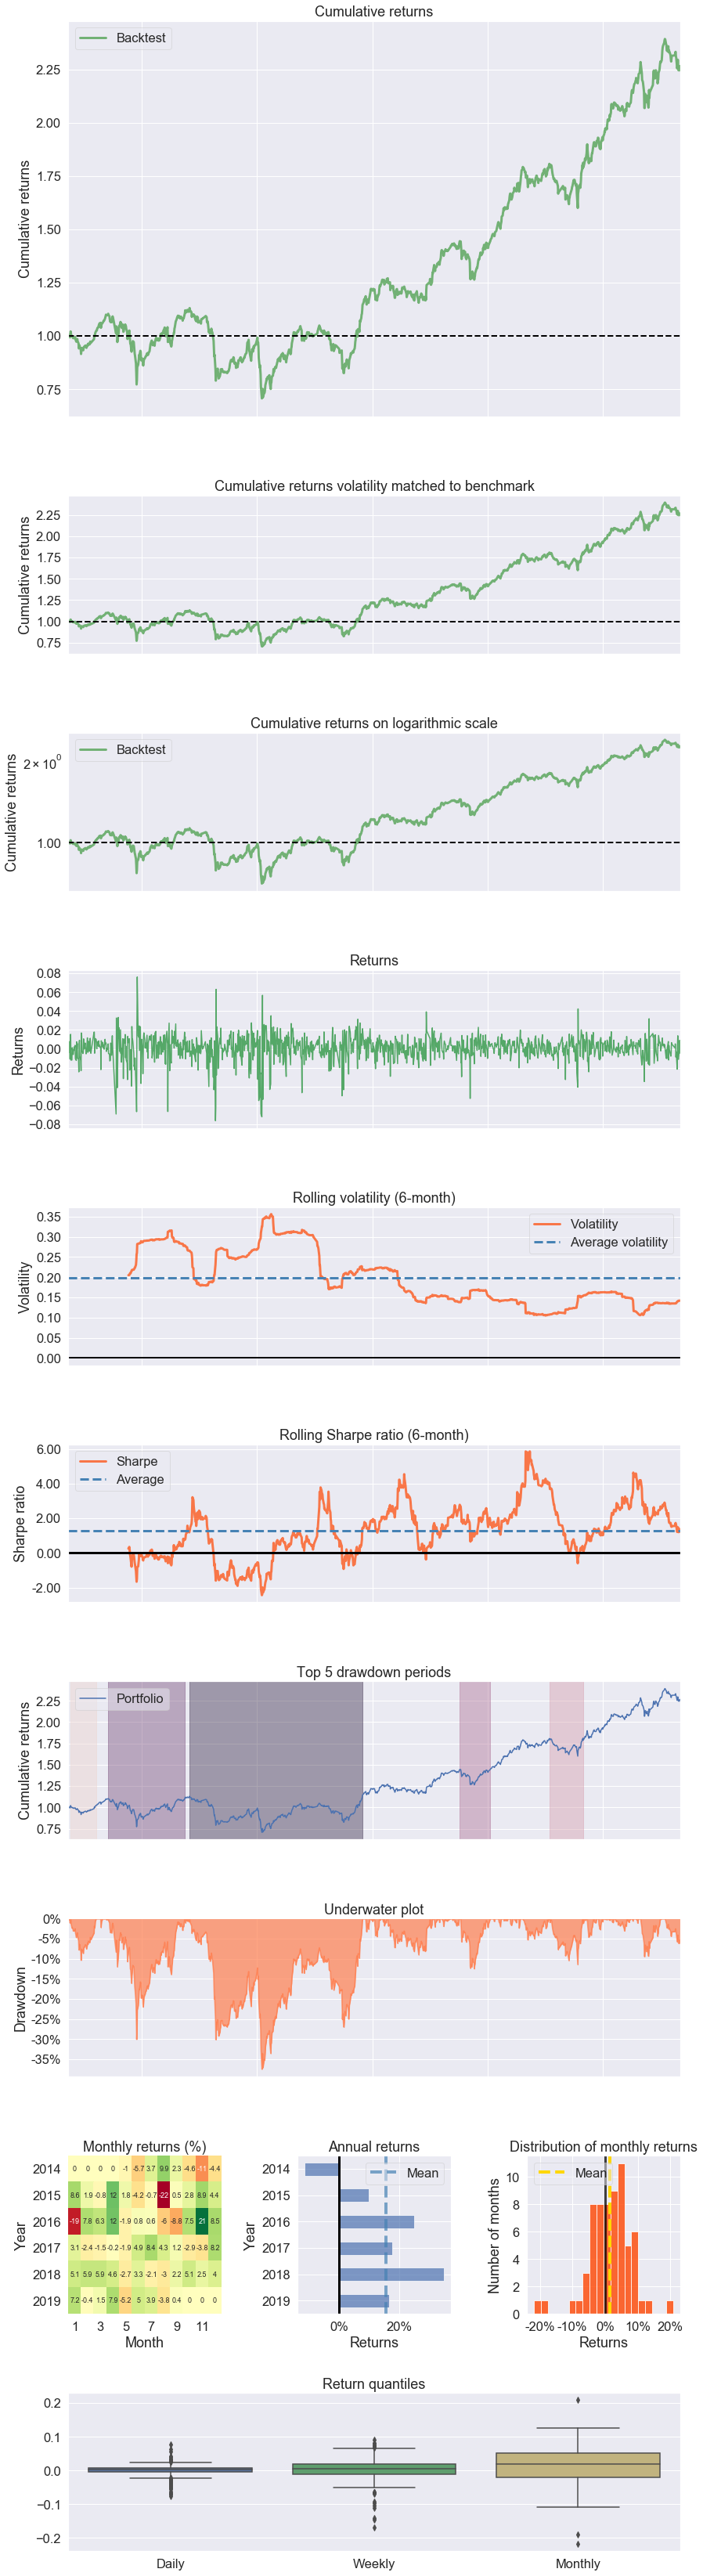

In [154]:
pf.create_returns_tear_sheet(fdr)